# CEIA - Visión por computadora 2

Integrantes del equipo:

* a1604 | Federico Arias Suárez | f_ariassuarez@hotmail.com
* a1618 | Myrna Lorena,Degano | myrna.l.degano@gmail.com
* a1620 | Gustavo Julián Rivas | gus.j.rivas@gmail.com


## Conjunto de datos

### Descripción

https://universe.roboflow.com/myworkspace-iraqv/wildfire_full  
<br>
* <u>Tipo de problema a resolver</u>: Detección de objetos.  
<br>
* <u>Objetivo</u>: Detectar focos de incendio.  
<br>
* <u>Motivación</u>: La Amazonía se está quemando a un ritmo alarmante, afectando el clima, la biodiversidad y el calentamiento global.
Detectar incendios de manera temprana podría marcar la diferencia para evitar daños mayores.

* <u>Créditos</u>:  

 - **title**: Wildfire_Full Dataset
 - **type**: Open Source Dataset
 - **author**: MyWorkspace
 - **URL**: https://universe.roboflow.com/myworkspace-iraqv/wildfire_full
 - **published**: Roboflow Universe
 - **publisher**: Roboflow
 - **year**: 2024
 - **month**: oct

In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
import os, shutil, random, yaml, json, math, torch, argparse, glob, gdown, zipfile

import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from tqdm import tqdm
from roboflow import Roboflow
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from PIL import Image, ImageDraw, ImageFont
from collections import Counter, defaultdict
from pathlib import Path


In [ ]:
# Download desde Roboflow
rf = Roboflow(api_key="tvpbe4I4XLcB14dkNovn")
project = rf.workspace("myworkspace-iraqv").project("wildfire_full")
version = project.version(1)

loading Roboflow workspace...
loading Roboflow project...


### Descarga

In [ ]:
def printREADME(readme_file_name, download_path, files_in_directory):
  """
  Función para imprimir los datos del README del dataset
  """

  readme_path = os.path.join(download_path, readme_file_name)

  if readme_file_name in files_in_directory:
    with open(readme_path, 'r') as readme_file:
        readme_content = readme_file.read()

        start_pos = readme_content.find("The dataset includes")

        if start_pos != -1:
            print(readme_content[start_pos:])

In [ ]:
def printFilesFolders(download_path):
  """
  Función para mostrar cómo está estructurado el dataset
  División en train-valid-test y cantidad de archivos
  """
  for dir in ['train', 'valid', 'test']:

    full_path = download_path + '/'  + dir + '/'

    print('\n\n-----')
    print(dir)
    print('-----')

    files = [f for f in Path(full_path).rglob('*') if f.is_file()]
    subdirectories = [f for f in Path(full_path).iterdir() if f.is_dir()]

    for subdir in subdirectories:
      print(f' - {subdir.name}')

    # Crear un defaultdict para contar las extensiones de archivo
    file_types_count = defaultdict(int)

    # Contar las ocurrencias de cada extensión en los archivos
    for f in files:
        _, extension = os.path.splitext(f)
        # Convertir la extensión a minúsculas
        extension = extension.lower()  # Convertir la extensión a minúsculas

        # Incrementar el contador para esa extensión
        file_types_count[extension] += 1

    # Imprimir las extensiones y sus cantidades para este directorio
    for ext, count in file_types_count.items():
        print(f"{count} archivos de extensión {ext}")


Se utiliza el dataset con anotaciones en formato COCO:

In [ ]:
format = 'coco'

In [ ]:
dataset_name = 'Wildfire_Full-1'
root_path = '/content/'
download_path = root_path + dataset_name

In [ ]:
# Download del conjunto de datos publicado en formato COCO
dataset = version.download(format)


Extracting Dataset Version Zip to Wildfire_Full-1 in coco:: 100%|██████████| 896/896 [00:00<00:00, 2219.23it/s]


In [ ]:
files_in_directory = os.listdir(download_path)

In [ ]:
printREADME('README.roboflow.txt', download_path, files_in_directory)

The dataset includes 888 images.
Fire are annotated in COCO format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.





In [ ]:
printFilesFolders(download_path)



-----
train
-----
622 archivos de extensión .jpg
1 archivos de extensión .json


-----
valid
-----
177 archivos de extensión .jpg
1 archivos de extensión .json


-----
test
-----
89 archivos de extensión .jpg
1 archivos de extensión .json


In [ ]:
new_dataset_name = dataset_name + '_' + format

dataset_path_coco = root_path + new_dataset_name

!mv "{download_path}" "{dataset_path_coco}"

In [ ]:
# Corregir definiciones de clases (sólo 2 -> Fire/Smoke)
for step in ['train', 'valid', 'test']:

  print(f'\n{step}:')
  # Cargar el archivo JSON de anotaciones
  annotations_file = f'{dataset_path_coco}/{step}/_annotations.coco.json'

  with open(annotations_file, 'r') as f:
      data = json.load(f)

  print(data['categories'])

  # Eliminar la categoría con id 0
  data['categories'] = [category for category in data['categories'] if category['id'] != 0]

  # Reindexar las categorías para que empiecen desde 1
  category_id_map = {category['id']: idx + 1 for idx, category in enumerate(data['categories'])}
  for category in data['categories']:
      category['id'] = category_id_map[category['id']]

  # Verificar las categorías después de la modificación
  print("Categorias después de eliminación y reindexación:")
  print(data['categories'])

  # Guardar el archivo JSON corregido
  with open(annotations_file, 'w') as f:
    json.dump(data, f)



train:
[{'id': 0, 'name': 'Fire', 'supercategory': 'none'}, {'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]
Categorias después de eliminación y reindexación:
[{'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]

valid:
[{'id': 0, 'name': 'Fire', 'supercategory': 'none'}, {'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]
Categorias después de eliminación y reindexación:
[{'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]

test:
[{'id': 0, 'name': 'Fire', 'supercategory': 'none'}, {'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]
Categorias después de eliminación y reindexación:
[{'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]


In [ ]:
classes_list = []

for category in data['categories']:

  classes_list.append(category['name'])

print(classes_list)


['Fire', 'Smoke']


## Modelo a evaluar

### Detectron 2 (RetinaNet)

https://github.com/facebookresearch/detectron2


Detectron2 es una biblioteca de código abierto desarrollada por Facebook AI Research (FAIR), diseñada para realizar tareas de visión por computadora utilizando modelos de aprendizaje profundo.

Detectron2 se basa en el uso de redes neuronales convolucionales (CNNs) para analizar imágenes y detectar patrones.


#### Set up

In [ ]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  2.5 ; cuda:  cu121


In [ ]:
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5ijgj4zw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5ijgj4zw
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.3 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp31

In [ ]:
import detectron2
import logging

from google.colab.patches import cv2_imshow

from detectron2 import model_zoo

from detectron2.config import get_cfg

from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader, build_detection_test_loader, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.data.transforms import *
from detectron2.data import detection_utils as utils

from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor

from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils import registry

from detectron2.structures import BoxMode

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

from detectron2.data import transforms as T
from detectron2.data.detection_utils import read_image


In [ ]:
# Instancia de Configuración del modelo
cfg = get_cfg()

In [ ]:
# Crear el directorio de salida donde se guardarán los modelos entrenados y otros archivos relacionados.
cfg.OUTPUT_DIR = "detectron2-output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
setup_logger()

<Logger detectron2 (DEBUG)>

#### Registrar datasets

Detectron2 necesita saber cómo leer y manejar el conjunto de datos antes de poder usarlo para el entrenamiento o la inferencia.   Por lo tanto, se deben registrar los conjuntos de datos COCO con la siguiente instrucción:

In [ ]:
register_coco_instances("coco_dataset_train", {}, dataset_path_coco + "/train/_annotations.coco.json", dataset_path_coco + "/train")
register_coco_instances("coco_dataset_valid", {}, dataset_path_coco + "/valid/_annotations.coco.json", dataset_path_coco + "/valid")
register_coco_instances("coco_dataset_test", {}, dataset_path_coco + "/test/_annotations.coco.json", dataset_path_coco + "/test")

In [ ]:
dataset_train_metadata = MetadataCatalog.get("coco_dataset_train")
dataset_train_dicts = DatasetCatalog.get("coco_dataset_train")

[12/06 14:58:07 d2.data.datasets.coco]: Loaded 622 images in COCO format from /content/Wildfire_Full-1_coco/train/_annotations.coco.json


In [ ]:
model = "COCO-Detection/retinanet_R_50_FPN_1x.yaml"

# Cargar la configuración preentrenada desde el modelo en el modelo_zoo de Detectron2
cfg.merge_from_file(model_zoo.get_config_file(model))

In [ ]:
# Conjuntos de datos
cfg.DATASETS.TRAIN = ("coco_dataset_train", )
cfg.DATASETS.TEST = ("coco_dataset_valid", )

# Número de procesos de trabajo para cargar datos de manera concurrente.
cfg.DATALOADER.NUM_WORKERS = 2

# Especificar pesos preentrenados como punto de partida
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
# Ajustar al número de clases del conjunto de datos
cfg.MODEL.RETINANET.NUM_CLASSES = 2

In [ ]:
# Parámetros de entrenamiento
#--------------------------------

cfg.SOLVER.IMS_PER_BATCH = 4 # Número de imágenes por lote (batch size).

n_epochs = 50 # Cantidad de épocas

cfg.SOLVER.BASE_LR = 0.001 # Tasa de aprendizaje inicial (learning rate).

cfg.SOLVER.MAX_ITER = (len(dataset_train_dicts)//cfg.SOLVER.IMS_PER_BATCH)*n_epochs # Número máximo de iteraciones (pasos) de entrenamiento.


In [ ]:
# Parámetros para evaluación
#--------------------------------
cfg.TENSORBOARD = True

cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5 # Umbral de confianza de la detección

cfg.TEST.EVAL_PERIOD = 500 # Cada cuántas iteraciones chequear métricas de validación


In [ ]:
if torch.cuda.is_available():
    cfg.MODEL.DEVICE = "cuda"  # Usar GPU si está disponible
else:
    cfg.MODEL.DEVICE = "cpu"   # Usar CPU si no hay GPU disponible

cfg.MODEL.DEVICE

'cuda'

### Evaluación de resultados

In [ ]:
# Descargar los resultados previamente entrenados
file_id = '1Toey-PailC7mv4EBP0ZqH2v_mCv5pnbk'
url = f'https://drive.google.com/uc?id={file_id}'

# Descargar el archivo ZIP al entorno de ejecución
gdown.download(url, 'models.zip', quiet=False)

# Descomprimir el archivo ZIP en el entorno de ejecución
with zipfile.ZipFile('models.zip', 'r') as zip_ref:
    zip_ref.extractall('./')


Downloading...
From (original): https://drive.google.com/uc?id=1Toey-PailC7mv4EBP0ZqH2v_mCv5pnbk
From (redirected): https://drive.google.com/uc?id=1Toey-PailC7mv4EBP0ZqH2v_mCv5pnbk&confirm=t&uuid=44a84978-d3a3-4b4d-aa2f-8212e8efdf6a
To: /content/models.zip
100%|██████████| 810M/810M [00:27<00:00, 29.9MB/s]


In [ ]:
results_dir = './models/'
# Resultados guardados de los tres experimentos
results_dir_E1 = results_dir +  'E1/'
results_dir_E2 = results_dir +  'E2/'
results_dir_E3 = results_dir +  'E3/'

In [ ]:
print(classes_list)

['Fire', 'Smoke']


Métricas:  

* **AP**: Promedio general de la precisión en varios umbrales de IoU.  
* **AP50**: Promedio de precisión cuando el umbral de IoU es 0.5.  
* **AP75**: Promedio de precisión cuando el umbral de IoU es 0.75.  
* **APs**: Promedio de precisión para objetos pequeños (área de caja < 1024 píxeles).  
* **APm**: Promedio de precisión para objetos medianos (área de caja entre 1024 y 9216 píxeles).
* **APl**: Promedio de precisión para objetos grandes (área de caja > 9216 píxeles).


#### 50 épocas con Augs

##### Métricas sobre el set de validación

In [ ]:
# Modelo entrenado - Métricas de validación
cfg.MODEL.WEIGHTS = os.path.join(results_dir_E1, "model_final.pth")

# Crear el predictor usando el modelo entrenado
predictor = DefaultPredictor(cfg)

evaluator_val = COCOEvaluator("coco_dataset_valid", cfg, False,  output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "coco_dataset_valid")

metrics_1 = inference_on_dataset(predictor.model, val_loader, evaluator_val)


[12/06 15:10:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./models/E1/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


WARNING [12/06 15:10:46 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/06 15:10:46 d2.data.datasets.coco]: Loaded 177 images in COCO format from /content/Wildfire_Full-1_coco/valid/_annotations.coco.json
[12/06 15:10:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/06 15:10:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/06 15:10:47 d2.data.common]: Serializing 177 elements to byte tensors and concatenating them all ...
[12/06 15:10:47 d2.data.common]: Serialized dataset takes 0.07 MiB
[12/06 15:10:47 d2.evaluation.evaluator]: Start inference on 177 batches
[12/06 15:10:48 d2.evaluation.evaluator]: Inference done 11/177. Dataloading: 0.0013 s/iter. Inference: 0.0678 s/iter. Eval: 0.0003 s/iter. Total: 0.06

In [ ]:
print("\nEvaluation Metrics (mAP (bbox)):\n")

for key, value in metrics_1.items():
    if isinstance(value, dict):

        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value:.4f}")
    else:
        print(f"{key}: {value:.4f}")


Evaluation Metrics (mAP (bbox)):

  AP: 9.0494
  AP50: 24.6972
  AP75: 4.8591
  APs: 4.0565
  APm: 6.1574
  APl: 12.2875
  AP-Fire: 7.8450
  AP-Smoke: 10.2538


#### 50 épocas sin Augs

##### Métricas sobre el set de validación

In [ ]:
# Modelo entrenado - Métricas de validación
cfg.MODEL.WEIGHTS = os.path.join(results_dir_E2, "model_final.pth")

# Crear el predictor usando el modelo entrenado
predictor = DefaultPredictor(cfg)

evaluator_val = COCOEvaluator("coco_dataset_valid", cfg, False,  output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "coco_dataset_valid")

metrics_2 = inference_on_dataset(predictor.model, val_loader, evaluator_val)

[12/06 15:11:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./models/E2/model_final.pth ...
WARNING [12/06 15:11:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


[12/06 15:11:15 d2.data.datasets.coco]: Loaded 177 images in COCO format from /content/Wildfire_Full-1_coco/valid/_annotations.coco.json
[12/06 15:11:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/06 15:11:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/06 15:11:15 d2.data.common]: Serializing 177 elements to byte tensors and concatenating them all ...
[12/06 15:11:15 d2.data.common]: Serialized dataset takes 0.07 MiB
[12/06 15:11:15 d2.evaluation.evaluator]: Start inference on 177 batches
[12/06 15:11:17 d2.evaluation.evaluator]: Inference done 11/177. Dataloading: 0.0080 s/iter. Inference: 0.0689 s/iter. Eval: 0.0003 s/iter. Total: 0.0772 s/iter. ETA=0:00:12
[12/06 15:11:22 d2.evaluation.evaluator]: Inference done 77/177. Dataloading: 0.0063 s/iter. Inference: 0.0695 s/iter. Eval: 0.0004 s/iter. Total: 

In [ ]:
print("\nEvaluation Metrics (mAP (bbox)):\n")

for key, value in metrics_2.items():
    if isinstance(value, dict):

        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value:.4f}")
    else:
        print(f"{key}: {value:.4f}")


Evaluation Metrics (mAP (bbox)):

  AP: 8.9157
  AP50: 25.0808
  AP75: 4.4478
  APs: 5.2513
  APm: 5.7935
  APl: 13.1232
  AP-Fire: 8.5114
  AP-Smoke: 9.3200


#### 100 épocas con Augs

##### Métricas sobre el set de validación

In [ ]:
# Modelo entrenado - Métricas de validación
cfg.MODEL.WEIGHTS = os.path.join(results_dir_E3, "model_final.pth")

# Crear el predictor usando el modelo entrenado
predictor = DefaultPredictor(cfg)

evaluator_val = COCOEvaluator("coco_dataset_valid", cfg, False,  output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "coco_dataset_valid")

metrics_3 = inference_on_dataset(predictor.model, val_loader, evaluator_val)

[12/06 15:11:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./models/E3/model_final.pth ...
WARNING [12/06 15:11:47 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


[12/06 15:11:47 d2.data.datasets.coco]: Loaded 177 images in COCO format from /content/Wildfire_Full-1_coco/valid/_annotations.coco.json
[12/06 15:11:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/06 15:11:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/06 15:11:47 d2.data.common]: Serializing 177 elements to byte tensors and concatenating them all ...
[12/06 15:11:47 d2.data.common]: Serialized dataset takes 0.07 MiB
[12/06 15:11:47 d2.evaluation.evaluator]: Start inference on 177 batches
[12/06 15:11:48 d2.evaluation.evaluator]: Inference done 11/177. Dataloading: 0.0012 s/iter. Inference: 0.0684 s/iter. Eval: 0.0003 s/iter. Total: 0.0699 s/iter. ETA=0:00:11
[12/06 15:11:53 d2.evaluation.evaluator]: Inference done 82/177. Dataloading: 0.0016 s/iter. Inference: 0.0684 s/iter. Eval: 0.0003 s/iter. Total: 

In [ ]:
print("\nEvaluation Metrics (mAP (bbox)):\n")

for key, value in metrics_3.items():
    if isinstance(value, dict):

        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value:.4f}")
    else:
        print(f"{key}: {value:.4f}")


Evaluation Metrics (mAP (bbox)):

  AP: 9.7196
  AP50: 26.0978
  AP75: 5.2753
  APs: 5.3314
  APm: 6.1187
  APl: 13.1642
  AP-Fire: 8.2019
  AP-Smoke: 11.2374


#### Comparativa de resultados

In [ ]:
metrics_1_bboxes = metrics_1['bbox']
metrics_2_bboxes = metrics_2['bbox']
metrics_3_bboxes = metrics_3['bbox']

df = pd.DataFrame({
    'Métrica': metrics_1_bboxes.keys(),
    'Experimento 1': metrics_1_bboxes.values(),
    'Experimento 2': metrics_2_bboxes.values(),
    'Experimento 3': metrics_3_bboxes.values()
})

display(df.style.hide(axis='index'))

## Inferencia sobre imágenes de prueba

Tomamos el último experimento que es el que dio mejores resultados para visualizar los resultados sobre el set de pruebas.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(results_dir_E3, "model_final.pth")
cfg.DATASETS.TEST = ("coco_dataset_test", )

cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5 # Umbral de confianza de la detección

predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("coco_dataset_test").set(thing_classes=["Fire", "Smoke"])
test_dataset_dicts = DatasetCatalog.get("coco_dataset_test")


[12/06 15:18:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./models/E3/model_final.pth ...
[12/06 15:18:45 d2.data.datasets.coco]: Loaded 89 images in COCO format from /content/Wildfire_Full-1_coco/test/_annotations.coco.json


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.




1)
Cantidad de detecciones: 3

 * Clase predicha: Smoke, Confianza: 99.98%
 * Clase predicha: Smoke, Confianza: 99.88%
 * Clase predicha: Smoke, Confianza: 99.82%


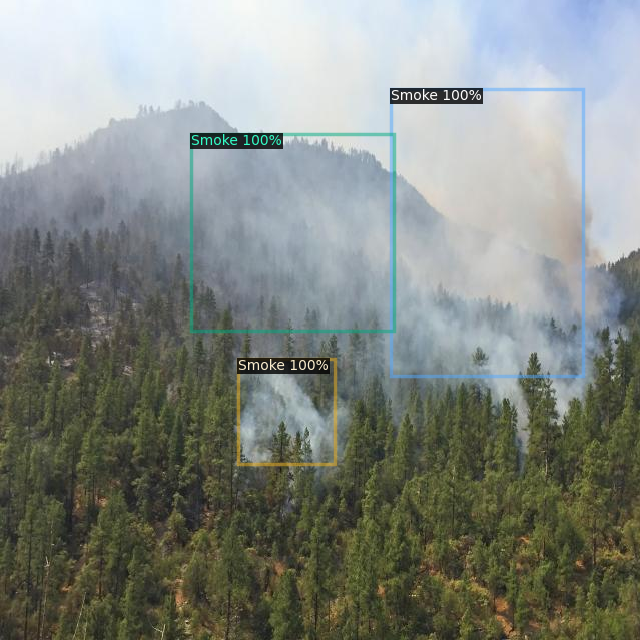



2)
Cantidad de detecciones: 1

 * Clase predicha: Smoke, Confianza: 99.12%


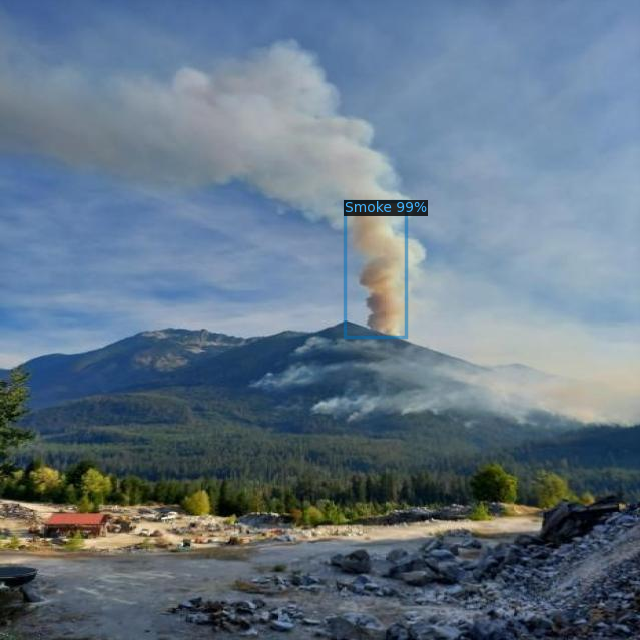



3)
Cantidad de detecciones: 3

 * Clase predicha: Smoke, Confianza: 92.98%
 * Clase predicha: Smoke, Confianza: 80.99%
 * Clase predicha: Smoke, Confianza: 80.21%


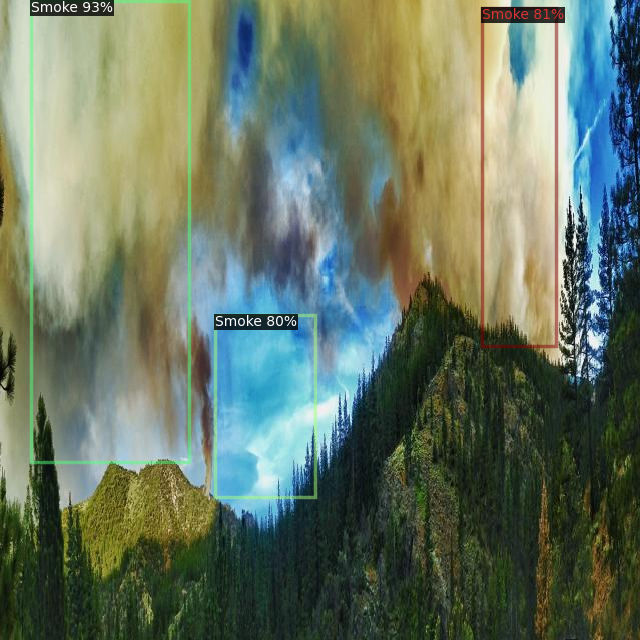



4)
Cantidad de detecciones: 3

 * Clase predicha: Smoke, Confianza: 96.34%
 * Clase predicha: Smoke, Confianza: 64.52%
 * Clase predicha: Smoke, Confianza: 62.65%


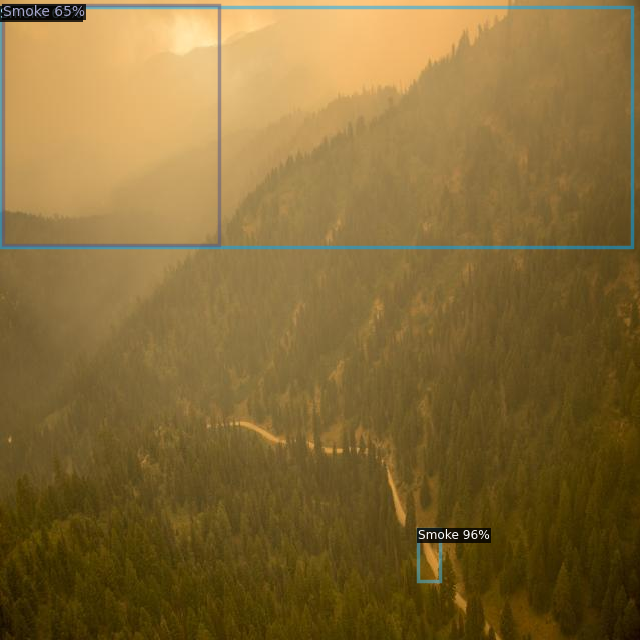



5)
Cantidad de detecciones: 7

 * Clase predicha: Smoke, Confianza: 96.53%
 * Clase predicha: Smoke, Confianza: 95.85%
 * Clase predicha: Smoke, Confianza: 87.42%
 * Clase predicha: Smoke, Confianza: 87.17%
 * Clase predicha: Smoke, Confianza: 86.83%
 * Clase predicha: Smoke, Confianza: 82.98%
 * Clase predicha: Smoke, Confianza: 62.55%


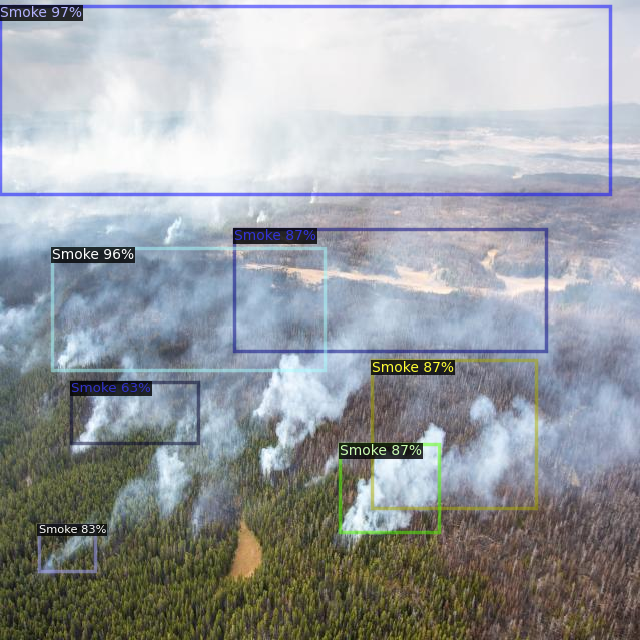

In [ ]:
# Obtener la lista de imágenes .jpg en el directorio de test
image_paths = glob.glob(dataset_path_coco + '/test/*jpg')

# Seleccionar una muestra aleatoria de imágenes
n_sample = 5
sample_images = random.sample(image_paths, n_sample)
class_names = classes_list.copy()

for i, imageName in enumerate(sample_images):

  im = cv.imread(imageName)
  outputs = predictor(im)

  print(f'\n\n{i + 1})')
  # Extraer las predicciones de boxes, scores y clases
  boxes = outputs["instances"].pred_boxes
  scores = outputs["instances"].scores
  classes = outputs["instances"].pred_classes

  # Obtener la cantidad de detecciones
  num_detections = len(scores)  # La cantidad de instancias detectadas

  # Convertir las clases y puntuaciones a formato de lista para visualización
  classes_np = classes.cpu().numpy()  # Mover a CPU y convertir a NumPy array
  scores_np = scores.cpu().numpy()    # Mover a CPU y convertir a NumPy array

  # Mostrar la cantidad de detecciones
  print(f"Cantidad de detecciones: {num_detections}\n")

  # Mostrar las clases predichas y sus respectivos porcentajes de confianza
  for i in range(num_detections):
      class_name = classes_list[classes_np[i]]
      print(f" * Clase predicha: {class_name}, Confianza: {scores_np[i] * 100:.2f}%")

  v = Visualizer(im[:, :, ::-1], metadata=test_metadata)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])



##### Comparativa de imágenes originales vs. predicciones



1)


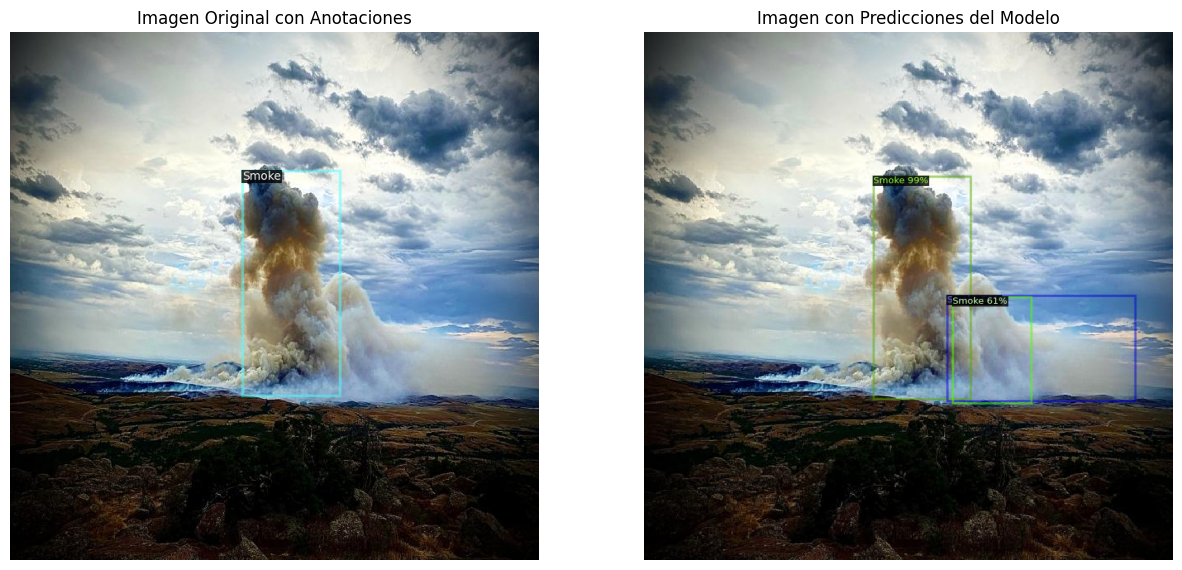



2)


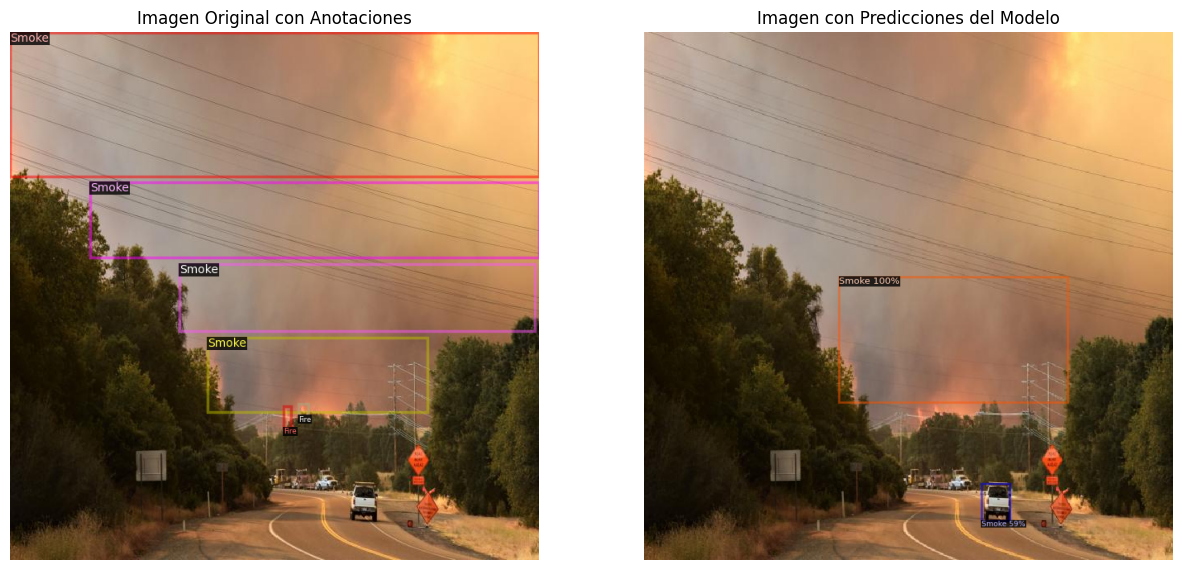



3)


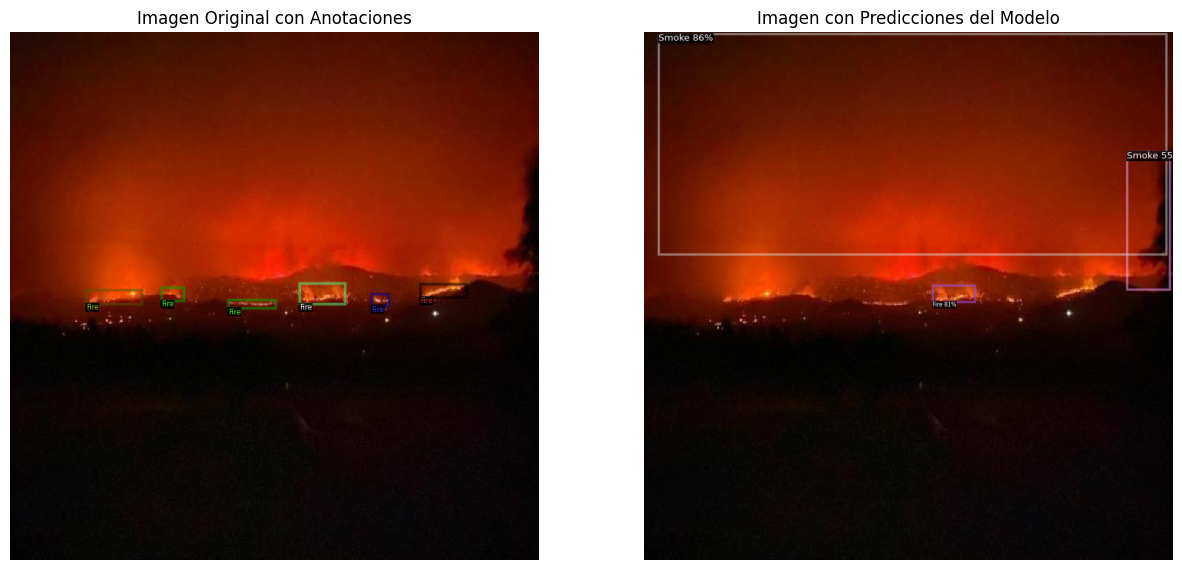



4)


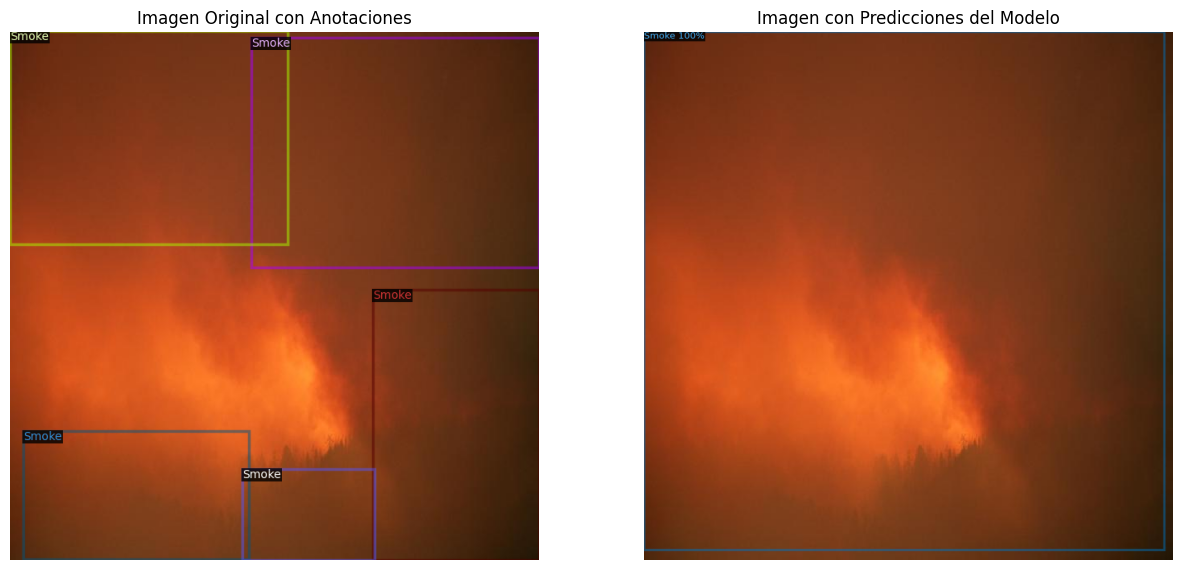



5)


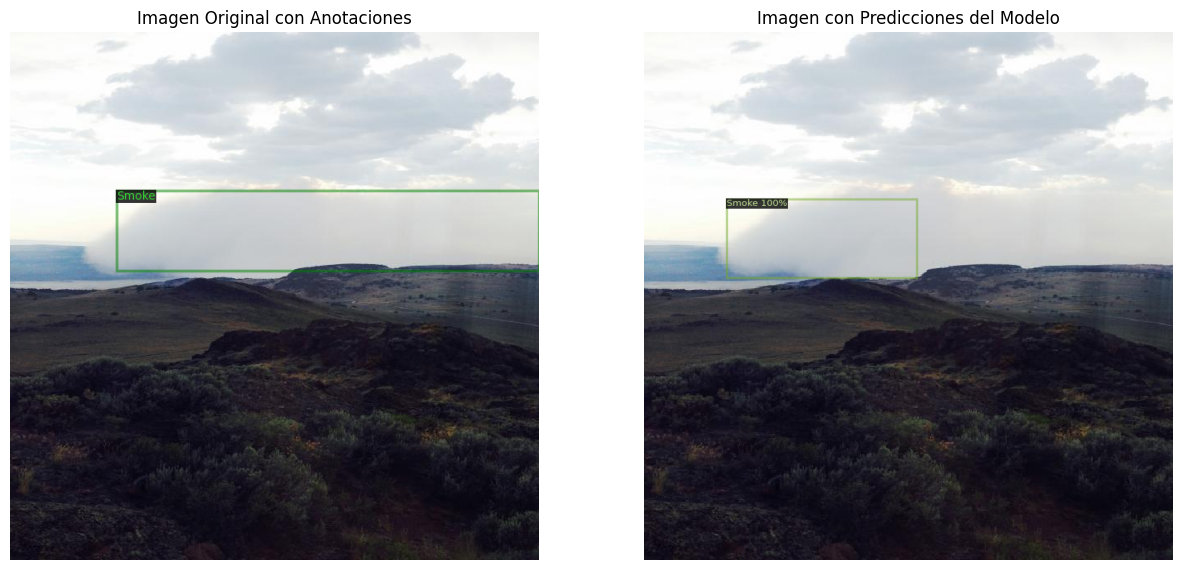

In [ ]:
# Obtener la lista de imágenes .jpg en el directorio de test
image_paths = glob.glob(dataset_path_coco + '/test/*jpg')

# Seleccionar una muestra aleatoria de imágenes
n_sample = 5
sample_images = random.sample(image_paths, n_sample)

for i, imageName in enumerate(sample_images):

    # Leer la imagen con OpenCV
    im = cv.imread(imageName)
    im_rgb = im[:, :, ::-1]  # Convertir de BGR a RGB

    # Buscar la anotación correspondiente para esta imagen (basado en el nombre)
    gt_annotation = None
    for dataset_dict in test_dataset_dicts:
        if dataset_dict["file_name"] == imageName:
            gt_annotation = dataset_dict
            break

    if gt_annotation is None:
        print("No se encontraron anotaciones para esta imagen.")
        continue

    # Visualizador para las anotaciones
    gt_v = Visualizer(im_rgb, metadata=test_metadata)
    gt_out = gt_v.draw_dataset_dict(gt_annotation)

    # Realizar la predicción del modelo
    outputs = predictor(im)  # Realizar la predicción

    print(f'\n\n{i + 1})')

    # Extraer las predicciones de boxes, scores y clases
    boxes = outputs["instances"].pred_boxes
    scores = outputs["instances"].scores
    classes = outputs["instances"].pred_classes

    # Obtener la cantidad de detecciones
    num_detections = len(scores)  # La cantidad de instancias detectadas

    # Convertir las clases y puntuaciones a formato de lista para visualización
    classes_np = classes.cpu().numpy()  # Mover a CPU y convertir a NumPy array
    scores_np = scores.cpu().numpy()    # Mover a CPU y convertir a NumPy array

    # Visualizar las imágenes
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # Subplot con 1 fila y 2 columnas

    # Mostrar la imagen original con sus anotaciones
    ax = axes[0]
    ax.imshow(gt_out.get_image())  # Mostrar imagen con las anotaciones de ground truth
    ax.set_title("Imagen Original con Anotaciones")
    ax.axis("off")  # Ocultar los ejes

    # Visualizar la imagen con las predicciones
    v = Visualizer(im_rgb, metadata=test_metadata, scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Mostrar la imagen con las predicciones
    ax = axes[1]
    ax.imshow(out.get_image())  # Mostrar imagen con las predicciones
    ax.set_title("Imagen con Predicciones del Modelo")
    ax.axis("off")  # Ocultar los ejes

    # Mostrar ambas imágenes lado a lado
    plt.show()


##### Métricas sobre el set de pruebas

In [ ]:
# Configurar el evaluador COCO
evaluator_test = COCOEvaluator("coco_dataset_test", cfg, False, output_dir=cfg.OUTPUT_DIR)

test_loader =  build_detection_test_loader(cfg,  "coco_dataset_test")

test_metrics = inference_on_dataset(predictor.model, test_loader, evaluator_test)


WARNING [12/06 15:21:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/06 15:21:49 d2.data.datasets.coco]: Loaded 89 images in COCO format from /content/Wildfire_Full-1_coco/test/_annotations.coco.json
[12/06 15:21:49 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    Fire    | 118          |   Smoke    | 178          |
|            |              |            |              |
|   total    | 296          |            |              |
[12/06 15:21:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/06 15:21:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/06 15:21:49 d2.data.co

In [ ]:
print("\nEvaluation Metrics (mAP (bbox)):\n")

for key, value in test_metrics.items():
    if isinstance(value, dict):

        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value:.4f}")
    else:
        print(f"{key}: {value:.4f}")


Evaluation Metrics (mAP (bbox)):

  AP: 11.5948
  AP50: 29.5253
  AP75: 6.9386
  APs: 4.2065
  APm: 9.1745
  APl: 12.7295
  AP-Fire: 6.4622
  AP-Smoke: 16.7275


In [ ]:
metrics_T_bboxes = test_metrics['bbox']

dfT = pd.DataFrame({
    'Métrica': metrics_3_bboxes.keys(),
    'Validación': metrics_3_bboxes.values(),
    'Test': metrics_T_bboxes.values(),
})

display(dfT.style.hide(axis='index'))

## Conclusiones

Como resultado de los experimentos, se observa que las métricas no son malas, pero hay aún espacio de mejora.   
Los valores de AP pueden mejorar con ajustes adicionales en la arquitectura, el entrenamiento o el conjunto de datos.  
<br>
<br>
**AP: 11.5948**  
Esta es la media general del modelo sobre todas las categorías.   
Un valor de 11.6% de mAP es relativamente bajo para modelos entrenados en el conjunto de datos COCO o VOC, especialmente al haber tomado como base un modelo de referencia como RetinaNet.   
Modelos de estado del arte, como los entrenados en COCO, generalmente tienen mAPs más altos (entre el 20% y 40% o más), dependiendo de la arquitectura y la calidad de los datos.  
<br>
**AP50: 29.5253**  
Este es el mAP calculado con un umbral de IoU = 0.5.   
El valor de 29.5% es bastante más alto que el mAP general, lo que sugiere que el modelo tiene un rendimiento decente cuando se permite un margen mayor de error en la coincidencia de las cajas delimitadoras.  
<br>
**AP75: 6.9386**  
Este es el mAP calculado con un umbral de IoU = 0.75, lo que es un umbral más estricto.   
El valor de 6.94% indica que el modelo tiene un desempeño menos sólido cuando se requiere una coincidencia precisa de las cajas delimitadoras. Esto es común en modelos que no están completamente afinados.  
<br>
**APs (Small objects): 4.2065**  
Indica el rendimiento en objetos pequeños.
Este valor es relativamente bajo, lo cual es normal para modelos que no están específicamente diseñados para detectar objetos pequeños.  
<br>
**APm (Medium objects): 9.1745**
Este es el rendimiento en objetos de tamaño medio.   
Un 9.17% está dentro del rango esperado, pero sigue siendo relativamente bajo comparado con modelos de última generación.  
<br>
**APl (Large objects): 12.7295**  
El desempeño con objetos grandes es más fuerte, lo cual es común, ya que los modelos de detección de objetos tienden a ser mejores con objetos más grandes.  
<br>
**AP-Fire: 6.4622**
Este es el mAP específico para la clase "Fire".   
Este es un valor relativamente bajo, lo que podría indicar que el modelo tiene problemas para detectar correctamente esta clase específica (Fuego).  
<br>
**AP-Smoke: 16.7275**
Este es un valor moderado para la clase "Smoke", lo que podría indicar que el modelo tiene un desempeño relativamente mejor para esta categoría. (Clasifica mejor el humo que el fuego).
<br><br>
Este puede ser un buen punto de partida para mejorar con más datos o ajustes en el modelo.  
<br><br>
En el contexto de detección de fuego y humo, los resultados para esas clases son razonables pero se pueden mejorar mediante técnicas adicionales:
* mejor etiquetado de datos (se observa visualizando el set de datos, que no todas las etiquetas se refieren claramente a humo/fuego, confundiéndose a veces luces o nubes).
* mejor balance de clases (las ocurrencias en el dataset de ambas clases no están completamente balanceadas).
* técnicas de data augmentation (explorar otras opciones de augmentation para aplicar y ver si mejoran el desempeño).

<br><br>
Asimismo, por cuestiones de límites de recursos no se entrenó por un mayor número de iteraciones, aunque la curva de la pérdida en entrenamiento se observa ya bastante estabilizada con esta configuración.

<br>

Sería preciso explorar variaciones sobre pipeline de augmentations, lo que podría mejorar el rendimiento, especialmente para introducir variaciones en escala o iluminación.

<br>

Otra opción interesante para explorar en esta arquitectura en particular, son los parámetros de Focal Loss.   
Su principal objetivo es centrarse en los ejemplos difíciles de clasificar (es decir, los ejemplos positivos y los falsos negativos) y disminuir la contribución de los ejemplos fáciles de clasificar (los negativos dominantes).
En el caso de Detectron2, que utiliza Focal Loss en su implementación de RetinaNet, los parámetros clave serían:  
* Alpha (Focal Loss Alpha): Este parámetro controla el balance entre la pérdida de las clases.
* Gamma (Focal Loss Gamma): Este parámetro controla el nivel de enfoque en los ejemplos difíciles.

<br>


De todas formas, comparando las detecciones del modelo con las imágenes y anotaciones reales, se observa que, a pesar de que el mAP no es suficientemente alto, las detecciones que está realizando son bastante acertadas y con niveles de confianza bastante altos.

Es interesante que las predicciones sean muy buenas visualmente (con altas probabilidades de confianza), pero que el mAP sea bajo.
Esto puede deberse a varios factores. Aunque la visualización muestra que el modelo detecta bien y con alta confianza, el mAP (mean Average Precision) es una métrica más rigurosa que considera varios aspectos de las predicciones y las comparaciones con las anotaciones reales.

Además de las predicciones correctas es preciso considerar:  

* Falsos Positivos (FP): Son las predicciones que el modelo hace y marca como un objeto detectado, pero que no coinciden con una anotación real (es decir, el modelo predice algo que no debería haber predicho).  
* Falsos Negativos (FN): Son los objetos que realmente existen en la imagen (según las anotaciones reales) pero que el modelo no ha detectado (es decir, no predice nada o no detecta el objeto correctamente).

En el contexto de detección de incendios es más importante minimizar los falsos negativos, ya que, es preferible que tengamos una falsa alarma, que un incendio real que no pudo ser mitigado a tiempo.
Por lo que, sería útil inspeccionar los ejemplos en los que el modelo cometió falsos negativos y así obtener una idea de por qué está fallando y realizar ajustes sobre los datos o los parámetros del modelo, mejorando su capacidad de detectar más objetos y aumentar el recall.
